
# Analog vs Digital Transmission


In this notebook we will explore the potential advantages of digital transmission over analog transmission. We will consider the case of transmission over a long (e.g. transoceanic) cable in which several repeaters are used to compensate for the attenuation introduced by the transmission.

Remember that if each cable segment introduces an attenuation of $1/G$, we can recover the original amplitude by boosting the signal with a repeater with gain $G$. However, if the signal has accumulated additive noise, the noise will be amplified as well so that, after $N$ repeaters, the noise will have been amplified $N$ times:

$$
    \hat{x}_N(t)  = x(t) + NG\sigma(t)
$$

If we use a digital signal, on the other hand, we can threshold the signal after each repeater and virtually eliminate the noise at each stage, so that even after several repeaters the trasmission is still noise-free.

Let's start with the standard initial bookkeeping...

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from scipy.io import wavfile

In [18]:
plt.rcParams["figure.figsize"] = (14,4)

Now we can read in an audio file from disk; we can plot it and play it back. The `wavfile.read()` function returns the audio data and the playback rate, which we will need to pass to the playback functions.

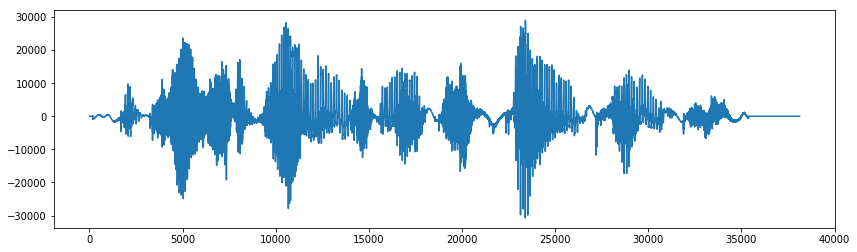

In [19]:
rate, s = wavfile.read('speech.wav')
plt.plot(s);
IPython.display.Audio(s, rate=rate)

## The "Analog" and "Digital" Signals ##

We will now create two version of the audio signal, an "analog" version and a "digital" version. Obviously the analog version is just a simulation, since we're using a digital computer; we will assume that, by using floating point values, we're in fact close enough to infinite precision. In the digital version of the signal, on the other hand, the audio samples will only take integer values between -100 and +100 (i.e. we will use approximately 8 bits per audio sample). 

In [20]:
# the analog signal is simply rescaled between -100 and +100
# largest element in magnitude:
norm = 1.0 / max(np.absolute([min(s), max(s)]))
sA = 100.0 * s * norm

# the digital version is clamped to the integers
sD = np.round(sA)

Rememeber that there is no free lunch and quantization implies a loss of quality; this initial loss (that we can minimize by using more bits per sample) is the price to pay for digital transmission. We can plot the error and compute the Signal to Noise Ratio (SNR) of the quantized signal

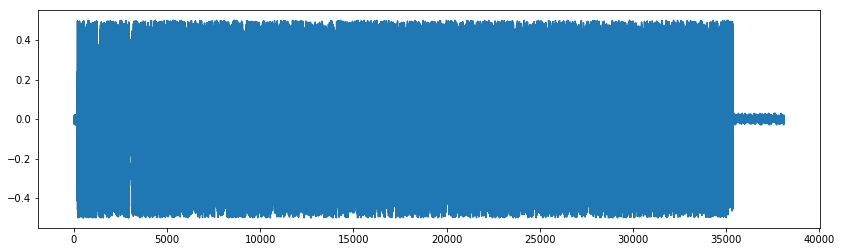

In [21]:
plt.plot(sA-sD);

as expected, the error is between -0.5 and +0.5, since in the "analog" signal the values are real-valued, whereas in the "digital" version they can only take integer values. As for the SNR,

In [22]:
# we will be computing SNRs later as well, so let's define a function
def SNR(noisy, original):
    # power of the error
    err = np.linalg.norm(original-noisy)
    # power of the signal
    sig = np.linalg.norm(original)
    # SNR in dBs
    return 10 * np.log10(sig/err)
    
    
print ('SNR = %f dB' % SNR(sD, sA))

SNR = 17.124344 dB


Can we hear the 17dB difference? A bit...

In [23]:
IPython.display.Audio(sA, rate=rate)

In [24]:
IPython.display.Audio(sD, rate=rate)

## Transmission ##

Let's now define a function that represents the net effect of transmitting audio over a cable segment terminated by a repeater:
* the signal is attenuated
* the signal is accumulates additive noise as it propagates through the cable
* the signal is amplified to the original amplitude by the repeater

In [25]:
def repeater(x, noise_amplitude, attenuation):
    # first, create the noise
    noise = np.random.uniform(-noise_amplitude, noise_amplitude, len(x))
    # attenuation
    x = x * attenuation
    # noise
    x = x + noise
    # gain compensation
    return x / attenuation

we can use the repeater for both analog and digital signals. Transmission of the analog signal is simply a sequence of repeaters:

In [26]:
def analog_tx(x, num_repeaters, noise_amplitude, attenuation):
    for n in range(0, num_repeaters):
        x = repeater(x, noise_amplitude, attenuation)
    return x

For digital signals, however, we can rectify the signal after each repeater, because we know that values should only be integer-valued:

In [27]:
def digital_tx(x, num_repeaters, noise_amplitude, attenuation):
    for n in range(0, num_repeaters):
        x = np.round(repeater(x, noise_amplitude, attenuation))
    return x

Let's compare transmission schemes

In [28]:
NUM_REPEATERS = 70
NOISE_AMPLITUDE = 0.2
ATTENUATION = 0.5

yA = analog_tx(sA, NUM_REPEATERS, NOISE_AMPLITUDE, ATTENUATION)
print ('Analog trasmission: SNR = %f dB' % SNR(yA, sA))    

yD = digital_tx(sD, NUM_REPEATERS, NOISE_AMPLITUDE, ATTENUATION)
print ('Digital trasmission: SNR = %f dB' % SNR(yD, sA))    

Analog trasmission: SNR = 8.708334 dB
Digital trasmission: SNR = 17.124344 dB


As you can see, the SNR after digital transmission has not changed! Now the difference between audio clips should be easy to hear:

In [29]:
IPython.display.Audio(yA, rate=rate)

In [30]:
IPython.display.Audio(yD, rate=rate)

Note however that, if the noise amplitude exceeds a certain value, digital transmission degrades even less gracefully than analog transmission:

In [31]:
NOISE_AMPLITUDE = 0.3

yA = analog_tx(sA, NUM_REPEATERS, NOISE_AMPLITUDE, ATTENUATION)
print ('Analog trasmission: SNR = %f dB' % SNR(yA, sA))   

yD = digital_tx(sD, NUM_REPEATERS, NOISE_AMPLITUDE, ATTENUATION)
print ('Digital trasmission: SNR = %f dB' % SNR(yD, sA))   

Analog trasmission: SNR = 6.978576 dB
Digital trasmission: SNR = 6.245571 dB


In [32]:
IPython.display.Audio(yA, rate=rate)
IPython.display.Audio(yD, rate=rate)